In [1]:
# !conda env create -f /kaggle/input/condaenv/environment.yml
# !conda init
# !conda activate pestvision
# !wget -P /kaggle/input/ https://storage.googleapis.com/npss-pestvision-data/pestvision_data.zip
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.4/778.4 kB 26.7 MB/s eta 0:00:00


In [2]:
import os
os.environ['WANDB_DISABLED'] = 'true'
import numpy as np
import torch
import yaml
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from abc import ABC, abstractmethod
from ultralytics import YOLO
import wandb
from wandb.integration.ultralytics import add_wandb_callback

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from glob import glob
# from natsort import natsorted
from PIL import Image
import torchvision.transforms as T
import xml.etree.ElementTree as ET
from typing import List, Tuple, Optional, Callable, Dict, Any

wandb: WARNING This integration is tested and supported for ultralytics v8.0.238 and below.
wandb: WARNING             Please report any issues to https://github.com/wandb/wandb/issues with the tag `yolov8`.


In [3]:
root = '/kaggle/input/pestvisiondata/pestvision/pestvision_data'
dset_paths = ['synthetic_data/DeepImageBlendingData/run3/RiceLeafs/images/train',
             'synthetic_data/DeepImageBlendingData/run3/paddy-disease-classification/images/train',
             'synthetic_data/Libcom_HarmonizationData_PCTNet/run1/RiceLeafs/images/train',
             'synthetic_data/Libcom_HarmonizationData_PCTNet/run1/paddy-disease-classification/images/train']
dset_paths = [os.path.join(root,i) for i in dset_paths]
val_paths = ["/".join(i.split('/')[:-1]+['val']) for i in dset_paths]

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available. Using GPU.")
else:
    device = torch.device('cpu')
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


In [4]:
class AbstractPestDetection(ABC):
    """
    Abstract class for pest detection
    """

    def __init__(self, device):
        self.device = device

    @abstractmethod
    def load_model(self, model_path):
        pass

    @abstractmethod
    def train(self):
        pass

    # TODO: implement evaluate method
    # @abstractmethod
    # def evaluate(self):
    #     pass


class PestDetection_yolov8(AbstractPestDetection):
    """
    YOLOv8 model for pest detection
    """

    def __init__(self, device):
        super().__init__(device)
        self.model = None

    def load_model(self, model_path):
        """
        Load the YOLOv8 model

        Parameters:

         model_path (str): path to the model checkpoint
        """

        self.model = YOLO(model_path)

    def train(self,**kwargs):

        results = self.model.train(**kwargs)
        self.model.val()

        return results

    # TODO: implment evaluate method
    # def evaluate(self):
    #     pass


In [5]:
def make_dsetconfig(train,val):

    d_config = {
        "train": train,
        "val": val,

        "nc": 102, # number of classes
        "names": [str(i) for i in range(1,103)] 
    }
    filename = 'data.yaml'
    with open(filename, 'w') as file:
        yaml.dump(d_config, file, default_flow_style=False)
    return filename

In [6]:
def train(checkpoint,train,val,resume = False):
    model = PestDetection_yolov8(device)
    model.load_model(checkpoint)
    results = model.train(data=make_dsetconfig(train,val), epochs=200, imgsz=512, save_period=10,batch=-1, plots=True, resume = resume)

In [7]:
import xml.etree.ElementTree as ET

def convert_to_yolo_format(annotation_file,dest):
    tree = ET.parse(annotation_file)
    root = tree.getroot()
    
    
    size = root.find('size')
    image_width = int(size.find('width').text)
    image_height = int(size.find('height').text)
    
    
    for obj in root.iter('object'):
        name = obj.find('name').text
        bndbox = obj.find('bndbox')
        
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
        
        x_center = (xmin + xmax) / 2.0 / image_width
        y_center = (ymin + ymax) / 2.0 / image_height
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height
        
        yolo_format = f"{name} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
        
        
        txt_filename = dest
        with open(txt_filename, 'w') as txt_file:
            txt_file.write(yolo_format + '\n')

In [8]:
annotations_path = '/kaggle/input/pestvisiondata/pestvision/pestvision_data/foreground_data/Detection_IP102/Annotations'
images_path = '/kaggle/input/pestvisiondata/pestvision/pestvision_data/foreground_data/Detection_IP102/JPEGImages'
label_path = 'data/labels/train/'
timage_path = 'data/images/train/'
if not os.path.isdir(label_path):
    os.makedirs(label_path)
if not os.path.isdir(timage_path):
    os.makedirs(timage_path)

for filename in os.listdir(annotations_path):
    
    if filename.endswith('.xml'):
        xml_file_path = os.path.join(annotations_path,filename)
        
        convert_to_yolo_format(xml_file_path,os.path.join(label_path,filename.replace('.xml','.txt')))
        image = imageio.imread(os.path.join(images_path,filename.replace('.xml','.jpg')))
        image.resize((512,512))
        imageio.imwrite(os.path.join(timage_path,filename.replace('.xml','.jpg')),image)



In [9]:
# train('/kaggle/input/yolo/other/exp1/6/last-5.pt', dset_paths, val_paths[1], True)

In [10]:
def segment(image):
    
    segment_size = 512
    if min(image.shape[0], image.shape[1])<512:
        segment_size = min(image.shape[0], image.shape[1])
    increment = int(segment_size*(3/4))

    images = []
    pos = []
    
    i = 0
    while i+segment_size<image.shape[0]:
        j = 0
        while j+segment_size<image.shape[1]:
            images.append(image[i:i+segment_size, j:j+segment_size])
            pos.append([i,i+segment_size, j,j+segment_size])
            j+=increment
        i+=increment
    
    i=0
    j=0
    while j+segment_size<image.shape[1]:
        images.append(image[image.shape[0]-segment_size:image.shape[0], j:j+segment_size])
        pos.append([image.shape[0]-segment_size,image.shape[0], j,j+segment_size])
        j+=increment
    while i+segment_size<image.shape[0]:
        images.append(image[i:i+segment_size,image.shape[1]-segment_size:image.shape[1]])
        pos.append([i,i+segment_size,image.shape[1]-segment_size,image.shape[1]])
        i+=increment
    
    images.append(image[image.shape[0]-segment_size:image.shape[0],image.shape[1]-segment_size:image.shape[1]])
    pos.append([image.shape[0]-segment_size,image.shape[0],image.shape[1]-segment_size,image.shape[1]])
    
    return images, pos, segment_size
    
        

def segment_eval(model, image):
    s_images, pos, sz = segment(image) 
    h,w = image.shape[0], image.shape[1]
    
    boxes = torch.empty((0,4),dtype = torch.int)
    confs = torch.empty((0))
    class_ids = torch.empty((0), dtype=torch.int)
    
    for sample_i, sample_pos in zip(s_images, pos):
        results = model.predict(sample_i)[0]
    
        sample_boxes = results.boxes.xyxy.clone()
        sample_boxes[:,0] = sample_boxes[:,0]+sample_pos[2]
        sample_boxes[:,1] = sample_boxes[:,1]+sample_pos[0]
        sample_boxes[:,2] = sample_boxes[:,2]+sample_pos[2]
        sample_boxes[:,3] = sample_boxes[:,3]+sample_pos[0]
        boxes = torch.cat((boxes,sample_boxes),dim=0)
        
        sample_conf = results.boxes.conf
        confs = torch.cat((confs,sample_conf),dim=0)
        
        sample_cids = results.boxes.cls
        class_ids = torch.cat((class_ids, sample_cids),dim=0)
    keep_indices = torch.ops.torchvision.nms(boxes, confs, 0.7)
    print(keep_indices)
        
    return boxes.to(torch.int)[keep_indices], confs[keep_indices], class_ids.to(torch.int)[keep_indices]

In [11]:
def plot_image_with_boxes(image, boxes, confidences, class_ids, class_names):
    """
    Plot image with bounding boxes.
    
    Args:
    - image: numpy array representing the image
    - boxes: list of bounding boxes in xyxy format
    - confidences: list of confidence scores
    - class_ids: list of class IDs
    - class_names: list of class names
    """
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box, confidence, class_id in zip(boxes, confidences, class_ids):
        x1, y1, x2, y2 = box
        box_width = x2 - x1
        box_height = y2 - y1
        
        # Create a rectangle patch
        rect = patches.Rectangle((x1, y1), box_width, box_height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Add class label and confidence score
        class_name = class_names[class_id]
        ax.text(x1, y1, f'{class_name} {confidence:.2f}', color='r', fontsize=8, backgroundcolor='none')

    plt.show()


0: 512x512 (no detections), 212.8ms
Speed: 11.8ms preprocess, 212.8ms inference, 10.3ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 102, 101.9ms
Speed: 1.4ms preprocess, 101.9ms inference, 11.7ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 106.8ms
Speed: 1.8ms preprocess, 106.8ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 111.0ms
Speed: 1.9ms preprocess, 111.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 102, 98.4ms
Speed: 1.9ms preprocess, 98.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 91.5ms
Speed: 1.8ms preprocess, 91.5ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)
tensor([1])


<Figure size 640x480 with 0 Axes>

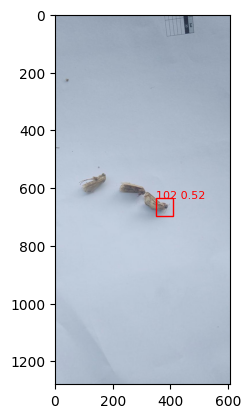

In [12]:
img = imageio.imread('/kaggle/input/pestvisiondata/images/images/8449aa5d-ad20-4428-983d-7132bf2e8cf5.jpg')

model = PestDetection_yolov8(device)
model.load_model('/kaggle/input/yolo/other/exp1/6/last-5.pt')
boxes, confs, class_ids = segment_eval(model.model, img)
plot_image_with_boxes(img,boxes,confs,class_ids,[str(i) for i in range(1,103)])

